In [1]:
import os
from scipy import ndimage
import nibabel as nib
from keras.utils import get_file
import torchio as tio
import numpy as np
import zipfile

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
url_1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
url_2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

file_path = "c:\\Users\\maxim\\OneDrive\\Desktop\\Research\\Experiment_1\\datasets\\CT-0.zip"
if os.path.exists(file_path):
    os.remove(file_path)  # Deletes the incomplete file

# Directory where the files will be stored
cache_dir = os.getcwd()  # Current working directory

# Download the first file
filename_1 = get_file("CT-0.zip", url_1, cache_dir=cache_dir)

# Download the second file
filename_2 = get_file("CT-23.zip", url_2, cache_dir=cache_dir)

# Make a directory to store the data
os.makedirs("CT_Data", exist_ok=True)  # Using exist_ok=True to avoid errors if the directory exists

# Unzip the first file
with zipfile.ZipFile(filename_1, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

# Unzip the second file
with zipfile.ZipFile(filename_2, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

1065471431/1065471431 ━━━━━━━━━━━━━━━━━━━━ 173s 0us/step
1045162547/1045162547 ━━━━━━━━━━━━━━━━━━━━ 118s 0us/step


In [7]:
def elastic_deformation(volume, num_control_points=5, max_displacement=10):
    """
    Apply elastic deformation to a volume (e.g., CT scan).
    :param volume: The input volume (e.g., a 3D numpy array or torch tensor).
    :param num_control_points: Number of control points used for the deformation.
    :param max_displacement: Maximum displacement (in voxels).
    :return: Deformed volume.
    """
    transform = tio.RandomElasticDeformation(num_control_points=num_control_points, max_displacement=max_displacement)
    
    # Add a channel dimension: (1, depth, height, width)
    volume_tio = tio.ScalarImage(tensor=volume[np.newaxis, ...])  
    transformed_volume = transform(volume_tio)  # Apply elastic deformation
    
    # Remove channel dimension before returning
    return transformed_volume.tensor.numpy()[0]

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(volume):
    """Read and resize volume"""

    volume = normalize(volume)
    volume = resize_volume(volume)
    volume = elastic_deformation(volume)
    
    return volume

In [10]:
def split_nii_files(input_dirs, output_root):
    """
    Splits each .nii.gz file in the specified directories into two equal parts 
    and saves them under the same subdirectory structure in the output directory.

    Parameters:
    - input_dirs (list): List of directories containing .nii.gz files.
    - output_root (str): Root directory where processed files will be stored.
    """

    # Ensure output root exists
    os.makedirs(output_root, exist_ok=True)

    for input_dir in input_dirs:
        # Define subdirectory in output root (e.g., Processed_CT/CT-0)
        study_name = os.path.basename(input_dir)
        study_output_dir = os.path.join(output_root, study_name)
        os.makedirs(study_output_dir, exist_ok=True)

        # Get all .nii.gz files in the directory
        nii_files = [f for f in os.listdir(input_dir) if f.endswith(".nii.gz")]

        for nii_file in nii_files:
            input_path = os.path.join(input_dir, nii_file)

            # Load the original NIfTI file
            img = nib.load(input_path)
            data = img.get_fdata()
            affine = img.affine  # Preserve spatial info
            header = img.header  # Preserve metadata

            data = process_scan(data)  # Preprocessing function (normalize, resize, etc.)

            # Get number of slices
            num_slices = data.shape[2]
            slices_per_part = num_slices // 2  # Two equal parts

            # Define a directory for the specific study
            file_study_name = os.path.splitext(nii_file)[0]  # Remove .nii.gz extension
            file_output_dir = os.path.join(study_output_dir, file_study_name)
            os.makedirs(file_output_dir, exist_ok=True)

            # Split into 2 parts
            for i in range(2):
                start_slice = i * slices_per_part
                end_slice = start_slice + slices_per_part

                if i == 1:  # Ensure last file gets all remaining slices
                    end_slice = num_slices

                # Extract subset of slices
                new_data = data[:, :, start_slice:end_slice]

                # Create new NIfTI image
                new_img = nib.Nifti1Image(new_data, affine, header)

                # Save new file
                output_file = os.path.join(file_output_dir, f"split_part_{i+1}.nii.gz")
                nib.save(new_img, output_file)
                print(f"Saved: {output_file}")

# Example usage:
input_dirs = ["./CT_Data/CT-0", "./CT_Data/CT-23"]
output_root = "Processed_CT"
split_nii_files(input_dirs, output_root)

Saved: Processed_CT\CT-0\study_0001.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0001.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0002.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0002.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0003.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0003.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0004.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0004.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0005.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0005.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0006.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0006.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0007.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0007.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0008.nii\split_part_1.nii.gz
Saved: Processed_CT\CT-0\study_0008.nii\split_part_2.nii.gz
Saved: Processed_CT\CT-0\study_0009.nii\

In [ ]:
base_path = './CT_Data/CT-0'
base_path_2 = './CT_Data/CT-23'


def delete_files(base_path):

    # Iterate through the files in CT_Data
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        # Check if it's a file and if it ends with '.gz'
        if os.path.isfile(item_path) and item.endswith('.gz'):
            os.remove(item_path)  # Delete the file
            print(f"Deleted file: {item_path}")


delete_files(base_path)
delete_files(base_path_2)

Deleted file: ./CT_Data/CT-0\study_0001.nii.gz
Deleted file: ./CT_Data/CT-0\study_0002.nii.gz
Deleted file: ./CT_Data/CT-0\study_0003.nii.gz
Deleted file: ./CT_Data/CT-0\study_0004.nii.gz
Deleted file: ./CT_Data/CT-0\study_0005.nii.gz
Deleted file: ./CT_Data/CT-0\study_0006.nii.gz
Deleted file: ./CT_Data/CT-0\study_0007.nii.gz
Deleted file: ./CT_Data/CT-0\study_0008.nii.gz
Deleted file: ./CT_Data/CT-0\study_0009.nii.gz
Deleted file: ./CT_Data/CT-0\study_0010.nii.gz
Deleted file: ./CT_Data/CT-0\study_0011.nii.gz
Deleted file: ./CT_Data/CT-0\study_0012.nii.gz
Deleted file: ./CT_Data/CT-0\study_0013.nii.gz
Deleted file: ./CT_Data/CT-0\study_0014.nii.gz
Deleted file: ./CT_Data/CT-0\study_0015.nii.gz
Deleted file: ./CT_Data/CT-0\study_0016.nii.gz
Deleted file: ./CT_Data/CT-0\study_0017.nii.gz
Deleted file: ./CT_Data/CT-0\study_0018.nii.gz
Deleted file: ./CT_Data/CT-0\study_0019.nii.gz
Deleted file: ./CT_Data/CT-0\study_0020.nii.gz
Deleted file: ./CT_Data/CT-0\study_0021.nii.gz
Deleted file:

In [11]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Example usage:
path = "Processed_CT/CT-23"
path2 = "Processed_CT/CT-0"
print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 100
Number of directories: 100


CT Scan Shape:  (128, 128, 32)


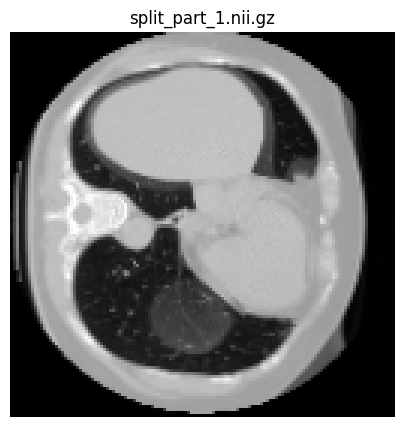

CT Scan Shape:  (128, 128, 32)


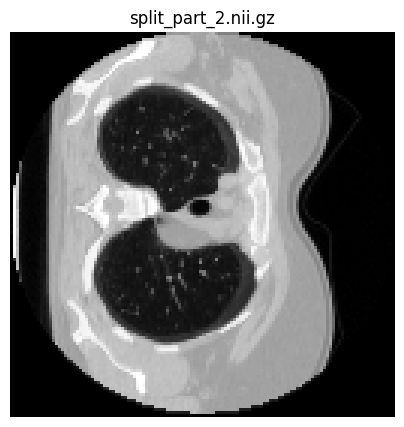

CT Scan Shape:  (128, 128, 32)


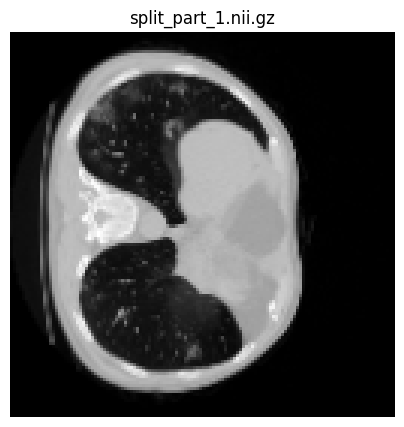

CT Scan Shape:  (128, 128, 32)


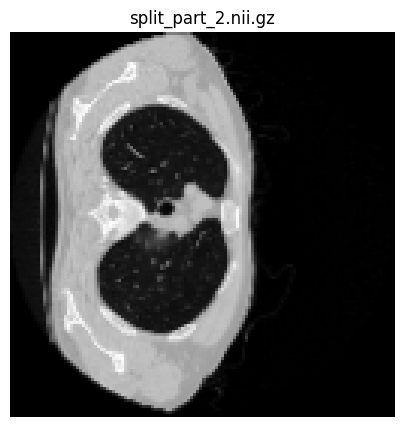

In [16]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

# Function to load and plot the NIfTI files from the specified directory
def plot_ct_scans_from_directory(study_dir):
    # Get all the .nii files in the directory
    nii_files = [f for f in os.listdir(study_dir) if f.endswith('.nii.gz')]
    
    # Plot each file
    for nii_file in nii_files:
        # Load the NIfTI file

        nii_path = os.path.join(study_dir, nii_file)
        img = nib.load(nii_path)
        volume = img.get_fdata()

        print("CT Scan Shape: ", np.array(volume).shape)

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.set_title(nii_file)
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./Processed_CT/CT-0/study_0080.nii"

plot_ct_scans_from_directory(study_directory)

study_directory = "./Processed_CT/CT-23/study_0965.nii"

plot_ct_scans_from_directory(study_directory)